In [88]:
import json
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet

In [89]:
import json

In [90]:
def download_data(tickers: list, start_date: str, end_date: str):
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)
    return data

In [91]:
tickers: list = ['AAPL', 'MSFT', 'JPM', 'XOM']
start_date: str = '2023-01-01'
end_date: str = '2023-12-31'

In [92]:
data = download_data(tickers, start_date, end_date)

[*********************100%***********************]  4 of 4 completed


In [93]:
df = data
df.describe().T

count          mean           std           min           25%  \
Ticker Price                                                                   
MSFT   Open    250.0  3.095453e+02  4.120718e+01  2.189604e+02  2.788697e+02   
       High    250.0  3.125723e+02  4.114498e+01  2.216704e+02  2.807424e+02   
       Low     250.0  3.066944e+02  4.102091e+01  2.153765e+02  2.771126e+02   
       Close   250.0  3.097909e+02  4.112924e+01  2.182829e+02  2.785646e+02   
       Volume  250.0  2.767556e+07  1.064023e+07  1.017660e+07  2.118648e+07   
JPM    Open    250.0  1.383366e+02  9.554943e+00  1.194118e+02  1.320440e+02   
       High    250.0  1.395177e+02  9.574688e+00  1.194593e+02  1.332420e+02   
       Low     250.0  1.372552e+02  9.811588e+00  1.170165e+02  1.310198e+02   
       Close   250.0  1.384851e+02  9.720425e+00  1.187274e+02  1.322364e+02   
       Volume  250.0  1.074558e+07  5.731891e+06  3.496900e+06  7.822975e+06   
XOM    Open    250.0  1.023507e+02  4.511013e+00  9.256175e+01  9.897712e+01   
       High    250.0  1.034023e+02  4.514375e+00  9.457894e+01  9.994977e+01   
       Low     250.0  1.012934e+02  4.452519e+00  9.154377e+01  9.789044e+01   
       Close   250.0  1.023350e+02  4.504474e+00  9.324353e+01  9.898419e+01   
       Volume  250.0  1.747948e+07  6.544464e+06  7.397000e+06  1.347562e+07   
AAPL   Open    250.0  1.708043e+02  1.759627e+01  1.245617e+02  1.599420e+02   
       High    250.0  1.723911e+02  1.733127e+01  1.263015e+02  1.607662e+02   
       Low     250.0  1.695404e+02  1.759867e+01  1.227429e+02  1.590956e+02   
       Close   250.0  1.710939e+02  1.739966e+01  1.235831e+02  1.604940e+02   
       Volume  250.0  5.921703e+07  1.777392e+07  2.404830e+07  4.781208e+07   

                        50%           75%           max  
Ticker Price                                             
MSFT   Open    3.208222e+02  3.330362e+02  3.801493e+02  
       High    3.247676e+02  3.366147e+02  3.806842e+02  
       Low     3.179190e+02  3.301926e+02  3.746020e+02  
       Close   3.204364e+02  3.334511e+02  3.790993e+02  
       Volume  2.505275e+07  2.996060e+07  7.847820e+07  
JPM    Open    1.364632e+02  1.435866e+02  1.651821e+02  
       High    1.374978e+02  1.445776e+02  1.658525e+02  
       Low     1.353813e+02  1.425111e+02  1.648226e+02  
       Close   1.367266e+02  1.436348e+02  1.654736e+02  
       Volume  9.219050e+06  1.131460e+07  4.393130e+07  
XOM    Open    1.018131e+02  1.053478e+02  1.139517e+02  
       High    1.027776e+02  1.063886e+02  1.146355e+02  
       Low     1.005433e+02  1.043855e+02  1.122517e+02  
       Close   1.014924e+02  1.054135e+02  1.141607e+02  
       Volume  1.583425e+07  1.944365e+07  5.793900e+07  
AAPL   Open    1.739699e+02  1.851958e+02  1.968382e+02  
       High    1.757370e+02  1.866961e+02  1.984286e+02  
       Low     1.725752e+02  1.835798e+02  1.958243e+02  
       Close   1.741983e+02  1.860608e+02  1.969277e+02  
       Volume  5.507750e+07  6.574292e+07  1.543573e+08

In [94]:
def compute_volume_features(ma_window=20):
    """Compute volume-based indicators for each stock."""
    volume_features = {}
    for ticker in tickers:
        volume = df[(ticker, "Volume")]
        ma_volume = volume.rolling(window=ma_window).mean()
        volume_change = volume.pct_change() * 100  # Convert to percentage
        volume_features[ticker] = {
            "Moving Average Volume": ma_volume,
            "Volume Change (%)": volume_change
        }
    return volume_features

In [95]:
def plot_stock_volume_vs_moving_average(ma_window=20):
    """Plots stock volume and its moving average for multiple tickers."""
    volume_features = compute_volume_features()
    plt.figure(figsize=(15, 8))  # Increased figure size

    for ticker in tickers:
        volume = data[(ticker, "Volume")]
        ma_volume = volume_features[ticker]['Moving Average Volume']

        plt.plot(df.index, volume, label=f"{ticker} Volume", alpha=0.7, linewidth=1.5)  # Improved line styling
        plt.plot(df.index, ma_volume, linestyle="--", label=f"{ticker} MA {ma_window}", linewidth=2)  # Improved line styling
    
    plt.viridis()
    plt.title("Stock Volume vs. Moving Average", fontsize=16, fontweight='bold')  # Improved title
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Volume", fontsize=12)
    plt.legend(fontsize=10) #Adjust legend font size
    plt.grid(True, linestyle='--', alpha=0.6)  # Improved grid
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

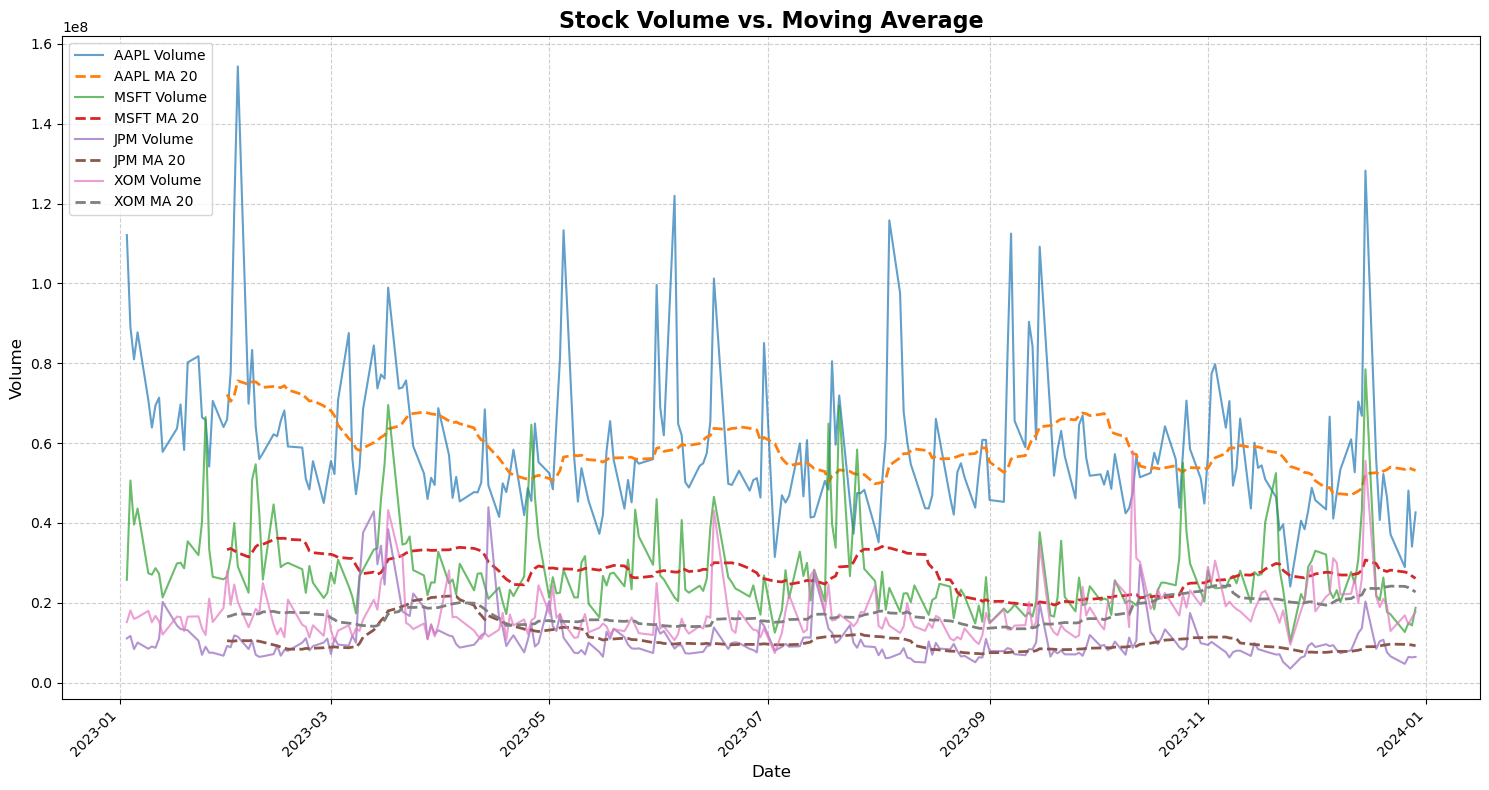

In [96]:
plot_stock_volume_vs_moving_average()

In [97]:
def plot_daily_volume_change():
    volume_features = compute_volume_features()
    
    plt.figure(figsize=(15, 8))
    for ticker in tickers:
        plt.plot(df.index, volume_features[ticker]['Volume Change (%)'], label=f"{ticker} Volume Change", alpha=0.7, linewidth=1.5)

    plt.title("Daily Volume Change (%)", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Percentage Change", fontsize=12)
    plt.axhline(y=0, color="black", linestyle="--", alpha=0.7)
    
    plt.legend(fontsize=10) #Adjust legend font size
    plt.grid(True, linestyle='--', alpha=0.6)  # Improved grid
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

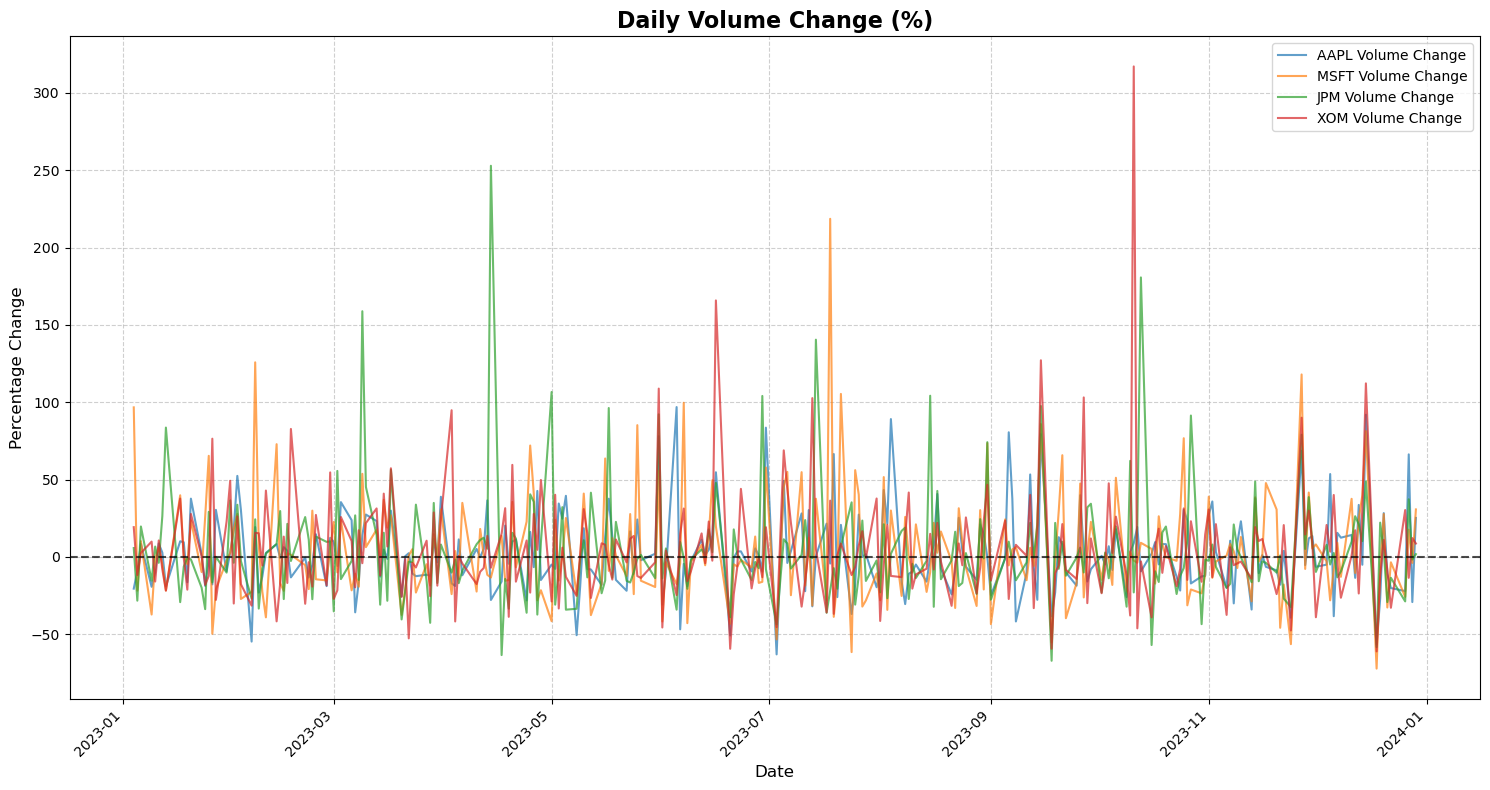

In [98]:
plot_daily_volume_change()

In [99]:
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [100]:
def compute_MACD(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

In [101]:
def compute_indicators_for_each_stock(ma_window=20):
    indicators = {}
    for ticker in tickers:
        close_price = df[(ticker, "Close")]
        volume = df[(ticker, "Volume")]

        ma_volume = volume.rolling(window=ma_window).mean()
        rsi = compute_RSI(close_price)
        macd, signal = compute_MACD(close_price)
        indicators[ticker] = {
            "Close": close_price, "Volume": volume, "MA_Volume": ma_volume, "RSI": rsi, "MACD": macd, "Signal": signal
        }
    return indicators

In [102]:
def plot_volume_surges_vs_price():
    indicators = compute_indicators_for_each_stock()
    plt.figure(figsize=(15, 8))  # Increased figure size

    for ticker in tickers:
        close_prices = indicators[ticker]['Close']
        volume_surges = indicators[ticker]['Volume']

        plt.plot(df.index, close_prices, label=f"{ticker} Price", linewidth=2) #Improved line style
        plt.scatter(df.index, volume_surges, s=20, label=f"{ticker} Volume", alpha=0.6) #Improved scatter style
    plt.viridis()
    plt.title("Stock Price vs. Volume Surges", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price & Volume", fontsize=12)

    plt.legend(fontsize=10) #Adjusted legend font size
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

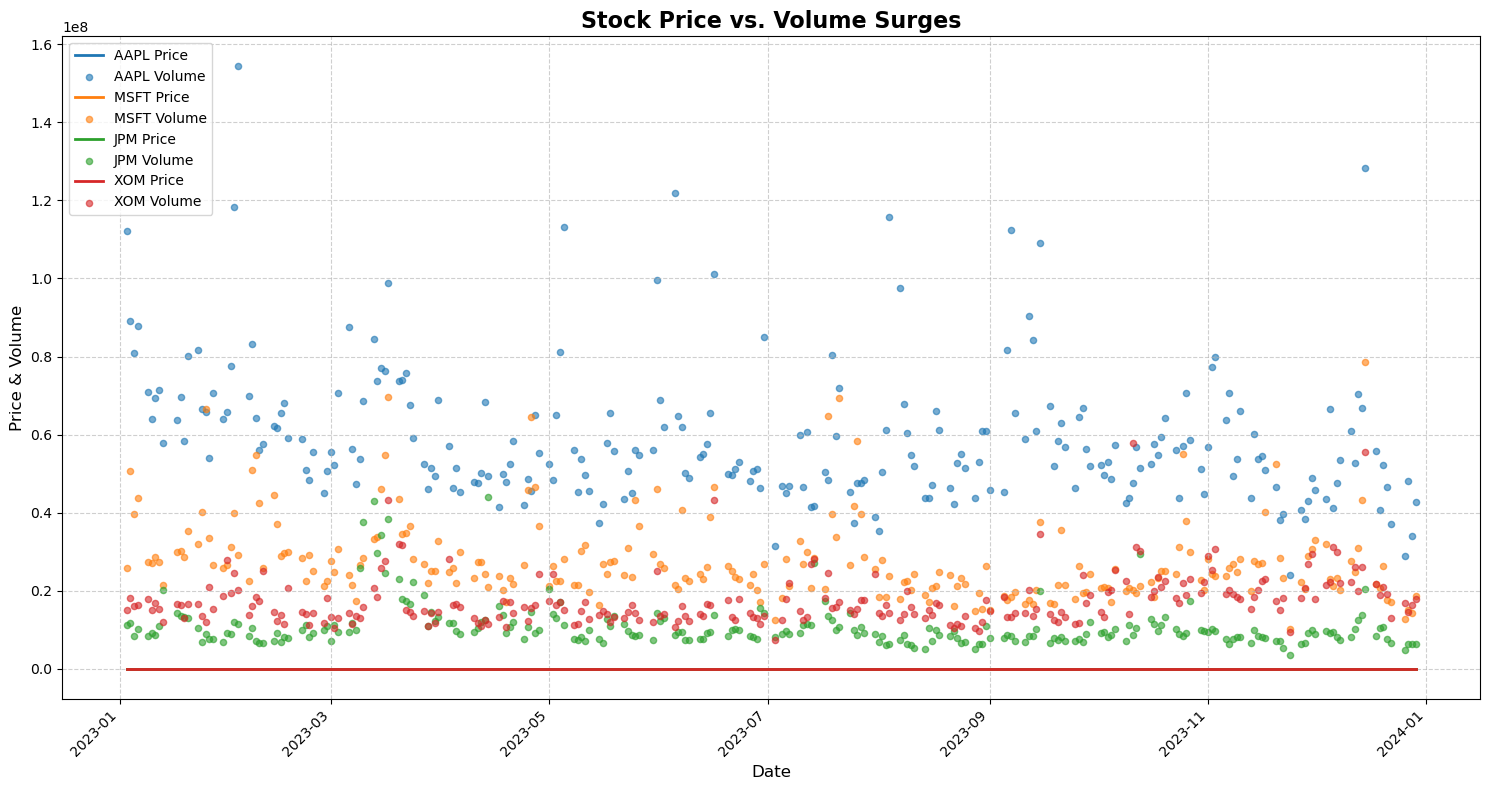

In [103]:
plot_volume_surges_vs_price()

In [104]:
def plot_rsi():
    indicators = compute_indicators_for_each_stock()
    
    plt.figure(figsize=(15, 8))  # Increased figure size
    
    for ticker in tickers:
        plt.plot(df.index, indicators[ticker]['RSI'], label=f"{ticker} RSI", alpha=0.7, linewidth=1.5)
        
    plt.axhline(70, linestyle="--", color="red", alpha=0.7)
    plt.axhline(30, linestyle="--", color="green", alpha=0.7)
    
    plt.title("RSI for Stocks", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("RSI", fontsize=12)
    plt.legend(fontsize=10) #Adjusted legend font size
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

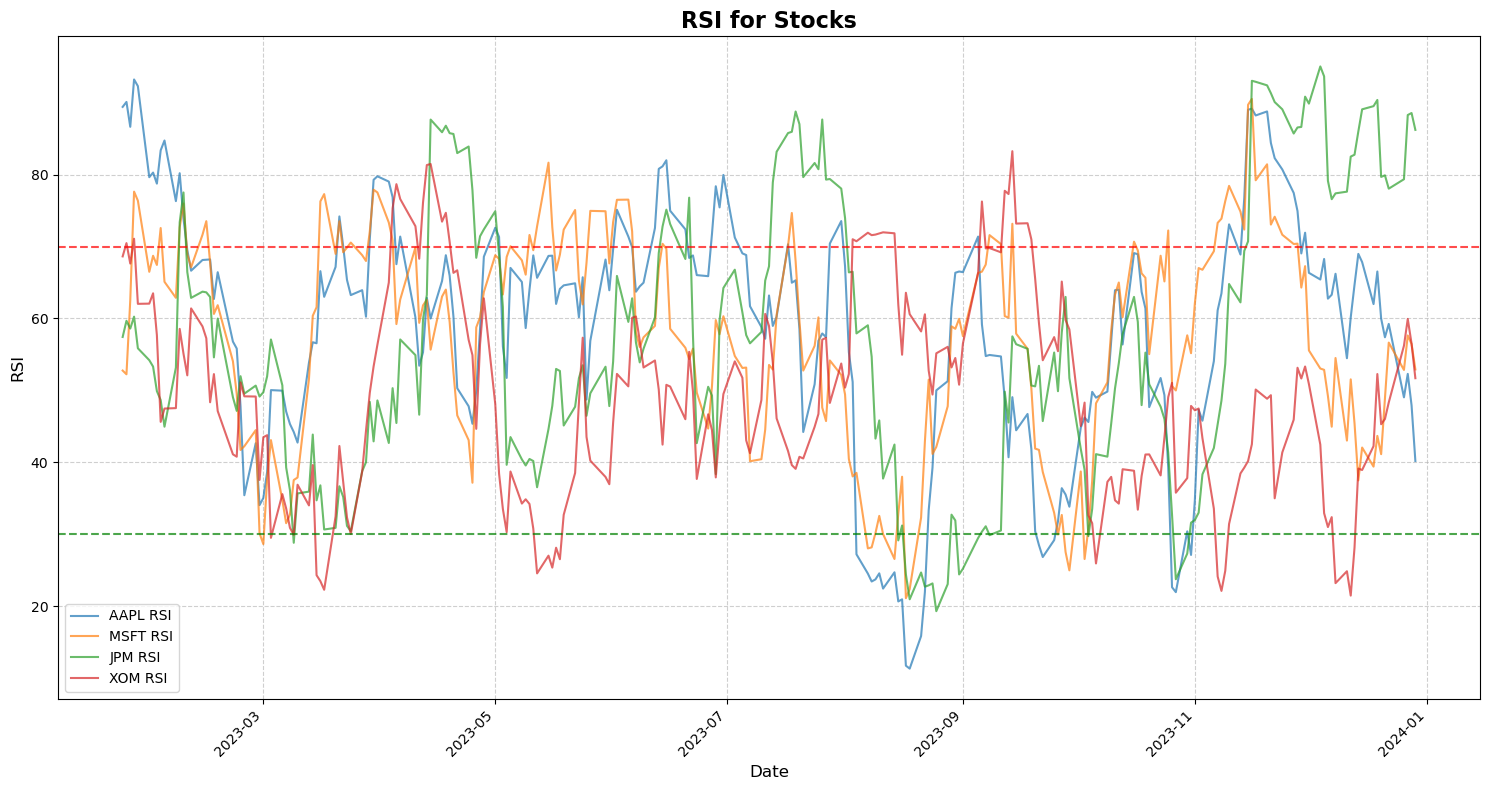

In [105]:
plot_rsi()

In [106]:
def plot_macd():
    indicators = compute_indicators_for_each_stock()
    
    plt.figure(figsize=(15, 8))  # Increased figure size
    
    for ticker in tickers:
        plt.plot(df.index, indicators[ticker]['MACD'], label=f"{ticker} MACD", alpha=0.7, linewidth=1.5)
        plt.plot(df.index, indicators[ticker]['Signal'], linestyle="--", label=f"{ticker} Signal", alpha=0.7, linewidth=1.5)

    plt.viridis()
    plt.axhline(0, linestyle="--", color="red", alpha=0.7)
    plt.title("MACD for Stocks", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("MACD", fontsize=12)
    plt.legend(fontsize=10) #Adjusted legend font size
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

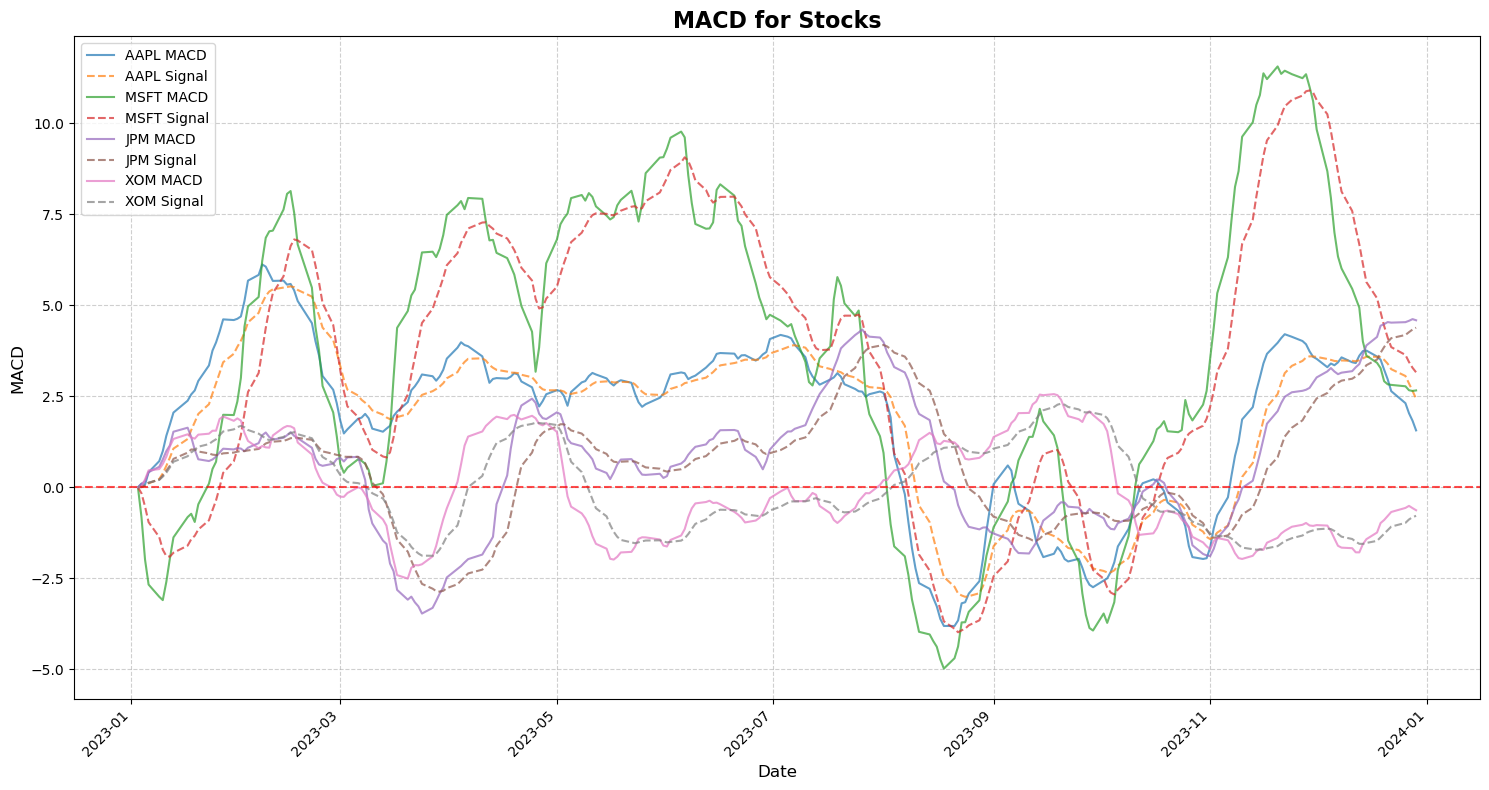

In [107]:
plot_macd()

In [108]:
def forecast_arima(series, steps=30):
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

In [109]:
def forecast_lstm(series, steps=30):
    series = series.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0,1))
    series_scaled = scaler.fit_transform(series)

    X, y = [], []
    lookback = 30
    for i in range(len(series_scaled) - lookback):
        X.append(series_scaled[i:i+lookback])
        y.append(series_scaled[i+lookback])

    X, y = np.array(X), np.array(y)
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
        LSTM(50), Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)

    future_inputs = series_scaled[-lookback:].reshape(1, lookback, 1)
    future_forecast = []
    for _ in range(steps):
        pred = model.predict(future_inputs)[0,0]
        future_forecast.append(pred)
        future_inputs = np.roll(future_inputs, -1)
        future_inputs[0, -1, 0] = pred

    future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1,1)).flatten()
    return future_forecast

In [110]:
volume_data_v1 = df[(tickers[0], "Volume")].dropna()
volume_data_v2 = {ticker: df[(ticker, "Volume")].dropna() for ticker in tickers}

In [111]:
def plot_volume_prediction():
    arima_forecast = forecast_arima(volume_data_v1, steps=30)
    lstm_forecast = forecast_lstm(volume_data_v1, steps=30)

    plt.figure(figsize=(15, 8))  # Increased figure size
    plt.plot(volume_data_v1[-300:], label="Actual Volume")
    plt.plot(pd.date_range(volume_data_v1.index[-1], periods=30, freq='D'), arima_forecast, label="ARIMA Forecast", linestyle="--",
            alpha=0.7, linewidth=1.5)
    plt.plot(pd.date_range(volume_data_v1.index[-1], periods=30, freq="D"), lstm_forecast, label="LSTM Forecast", linestyle="--",
            alpha=0.7, linewidth=1.5)
    plt.viridis()
    
    plt.title(f"Volume Prediction for {tickers[0]}", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Volume", fontsize=14)
    plt.legend(fontsize=10) #Adjusted legend font size
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

Epoch 1/20


C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0499
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0188
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0180
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0135
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0188
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0174
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0129
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0159
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0133
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0156
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0186
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0140
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0157
Epoch 16/20
14/

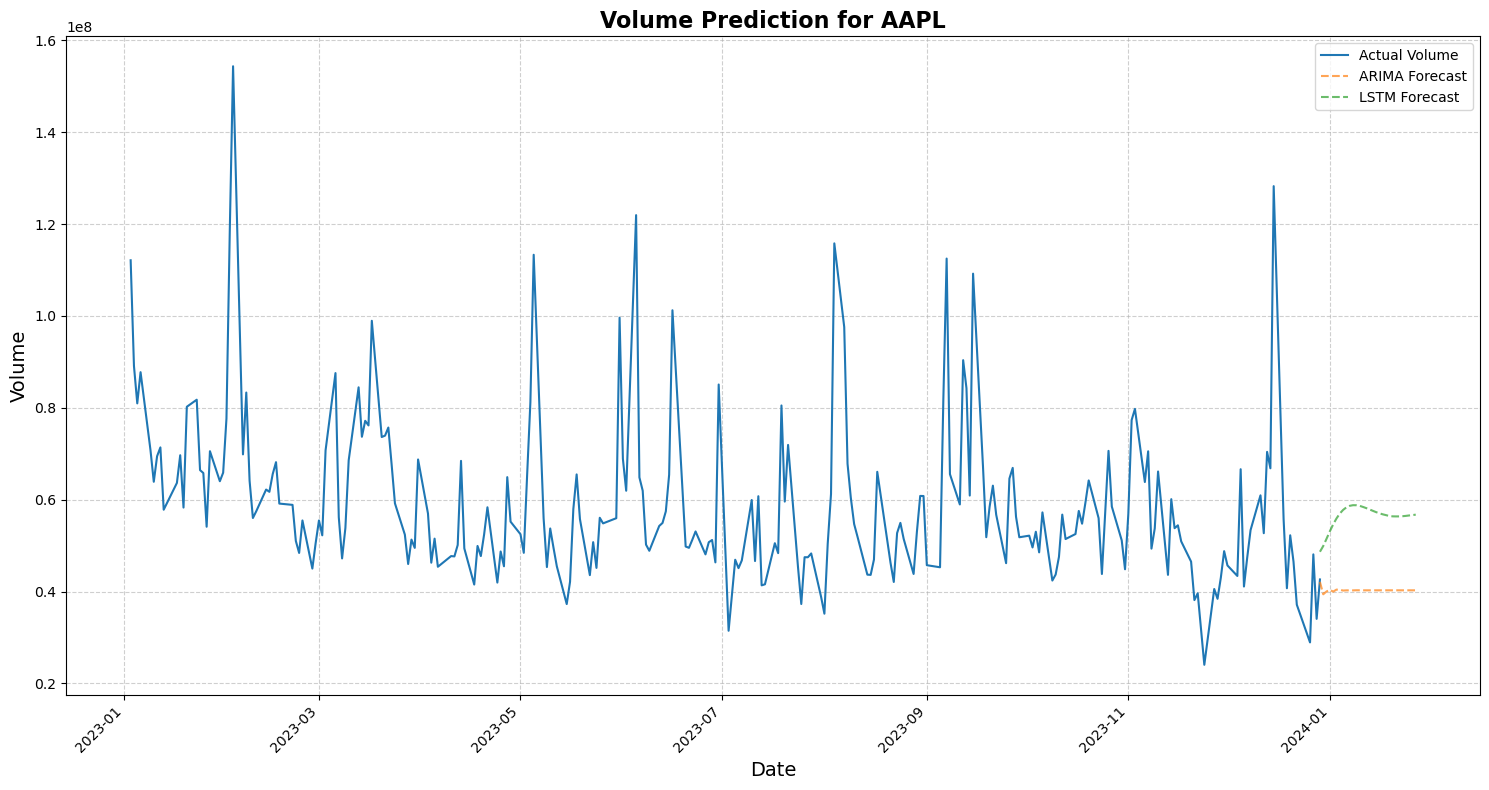

In [112]:
plot_volume_prediction()

In [113]:
def dataset_v2():
    df = pd.DataFrame(volume_data_v2)
    df.index.name = "Date"
    df.fillna(method="ffill")
    scaler = MinMaxScaler(feature_range=(0,1))
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=tickers, index=df.index)        
    return df, scaler, df_scaled

In [114]:
 def plot_original_volume_data():
     
    df, scaler, df_scaled = dataset_v2()
    df.plot(figsize=(15, 8), title='Stock Volume Data', alpha=0.7, linewidth=1.5)
    plt.ylabel("Volume", fontsize=14)
    plt.legend(fontsize=10) #Adjusted legend font size
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_22492\1922469782.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill")


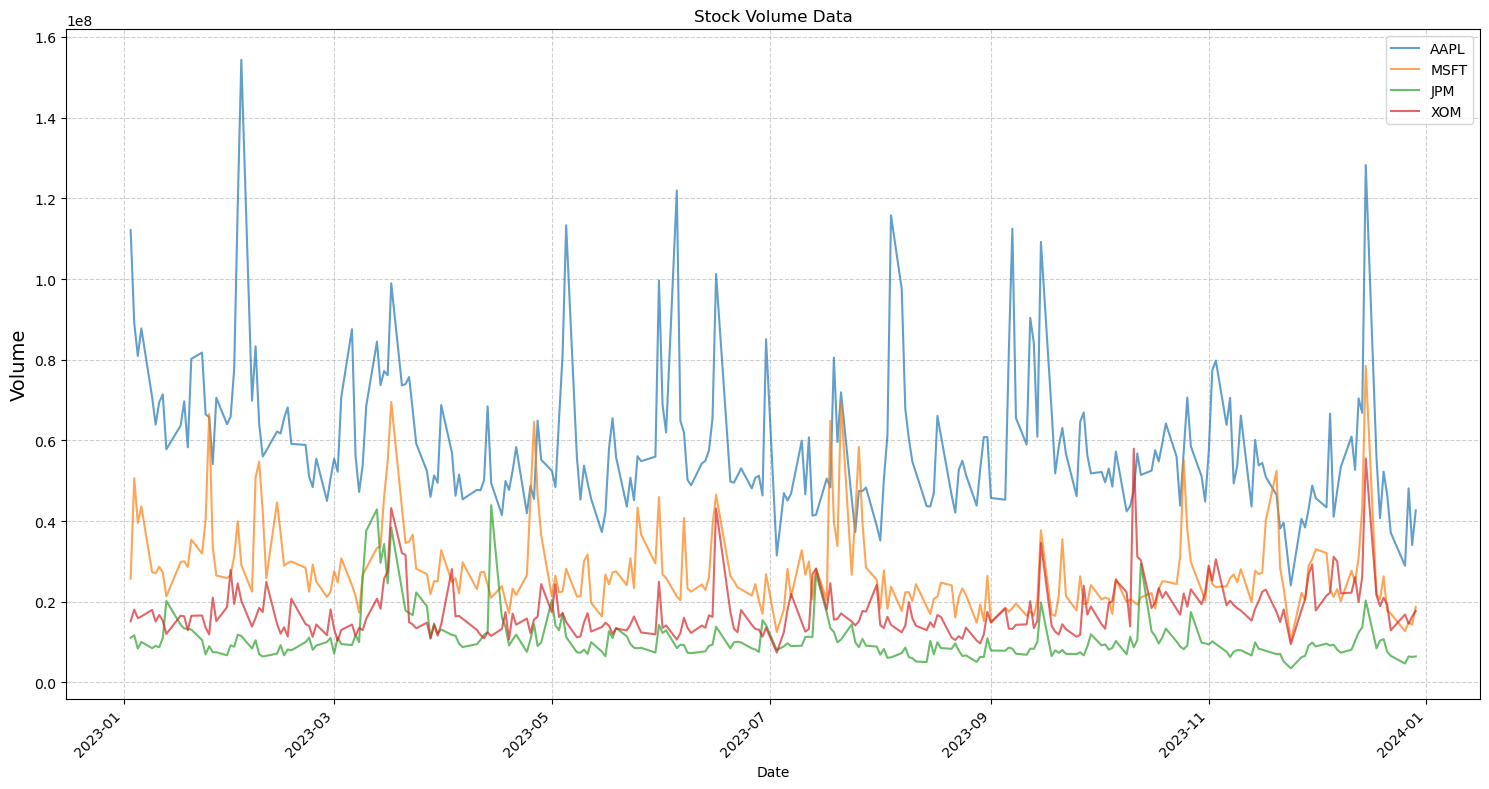

In [115]:
plot_original_volume_data()

In [116]:
def prepare_prophet_data(series):
    df_prophet = pd.DataFrame({'ds': series.index, 'y': series.values})
    return df_prophet

In [117]:
def plot_prophet_volume_prediction_for_multiple_stocks():
    df, scaler, df_scaled = dataset_v2()
    prophet_forecasts = {}
    future_dates = pd.date_range(df.index[-1], periods=30, freq='D')

    plt.figure(figsize=(18, 8))
    for ticker in tickers:
        prophet_df = prepare_prophet_data(df[ticker])
        model = Prophet()
        model.fit(prophet_df)
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)
        prophet_forecasts[ticker] = forecast['yhat'][-30:].values
        plt.plot(future_dates, forecast['yhat'][-30:], label=f"{ticker} Prophet Forecast", alpha=0.7, linewidth=1.5)

    plt.title("Prophet Volume Predictions for Multiple Stocks", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Volume", fontsize=14)
    plt.legend(fontsize=10) #Adjusted legend font size
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right') #Rotate x-axis labels
    plt.tight_layout()
    plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_22492\1922469782.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill")
18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
18:21:10 - cmdstanpy - INFO - Chain [1] start processing
18:21:10 - cmdstanpy - INFO - Chain [1] done processing
18:21:10 - cmdstanpy - INFO - Chain [1] start processing
18:21:10 - cmdstanpy - INFO - Chain [1] done processing


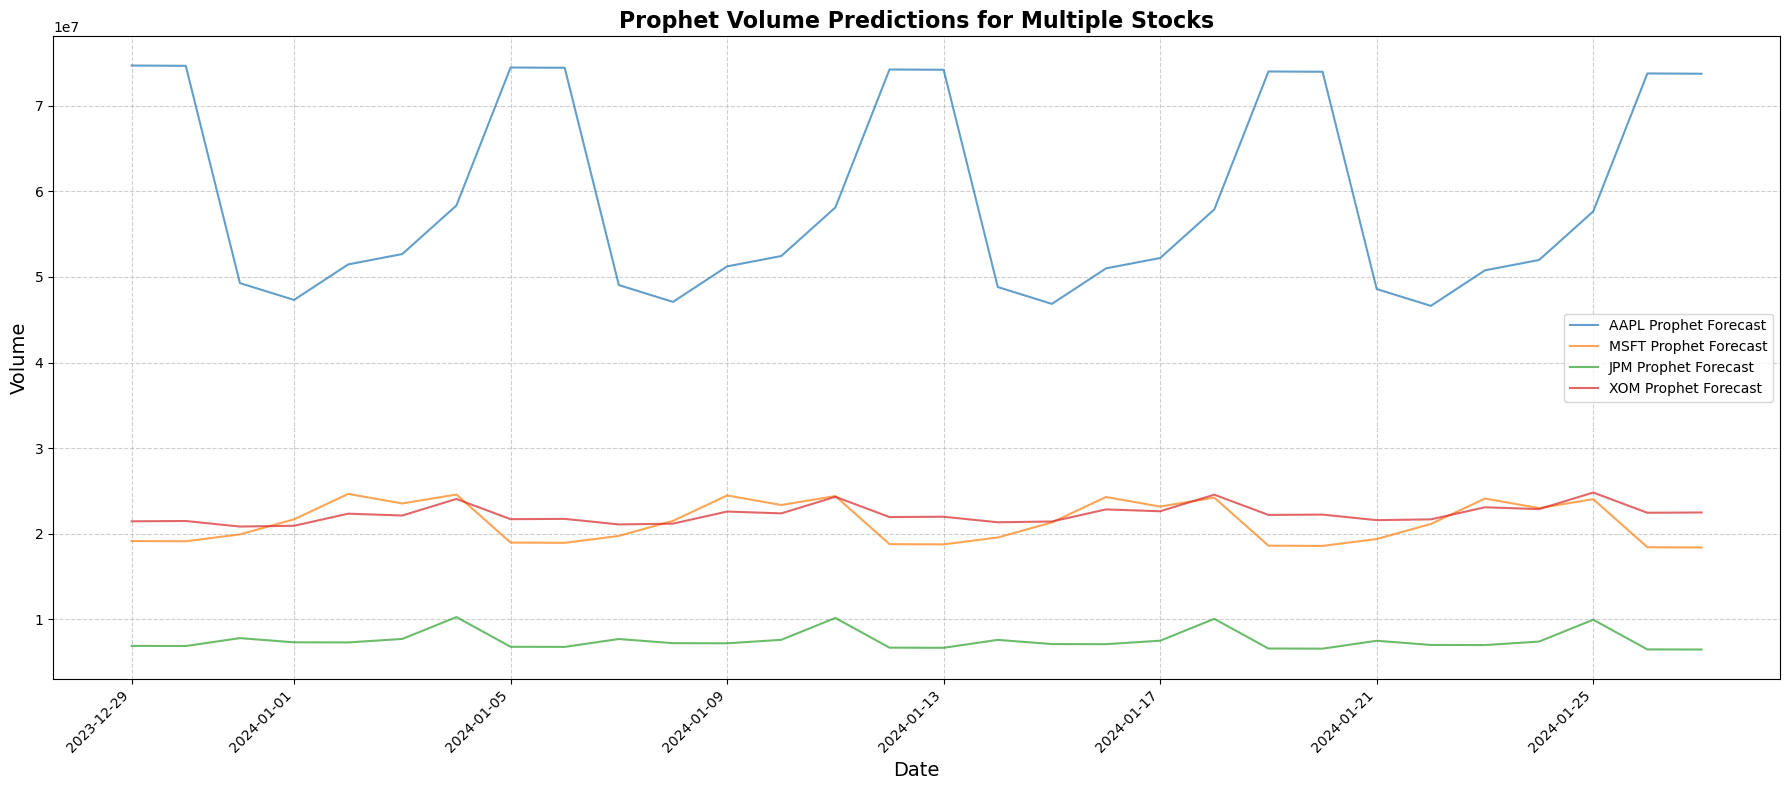

In [118]:
plot_prophet_volume_prediction_for_multiple_stocks()